# Compute optimal individual parameters for GMAC metric

In [100]:
from utilities import *
from individual_analysis_ac_functions import *
from extract_mask_from_video import *
from classification_algorithms import compute_vector_magnitude
import GMAC as gmac

In [101]:
#CHANGE VALUES HERE TODO
# H for Healthy and S for Stroke 
participant_id = 'S016'
participant_group = 'S'
using_Axivity = True

In [102]:
#PATH# 
initial_path = '../data/CreateStudy'#'../CreateStudy'
participant_path = os.path.join(initial_path, participant_id)
print(participant_path)

../data/CreateStudy/S014


In [103]:
# Extract dataset from the participant JSON file 
participant_data = load_participant_json(participant_id, initial_path)
# Get the correct handiness 
# For stroke, dominant hand = non affected hand 
dominant_hand = get_dominant_hand(participant_data)

In [104]:
# Get the data from IMU csv files 
ndh_data, chest_data, dh_data, GT_mask_25Hz_NDH, GT_mask_25Hz_DH = get_data(participant_path, dominant_hand, using_Axivity)
GT_mask_25Hz_NDH = GT_mask_25Hz_NDH.ravel()
GT_mask_25Hz_DH = GT_mask_25Hz_DH.ravel()
# Ensure the array sizes consistency between masks and IMU data
print(len(GT_mask_25Hz_NDH)*2, len(ndh_data))

58062 58062


In [105]:
sampling_freq = 50 # Hz
frequency_GMAC = 1 # Hz
FPS_mask = 25 # Hz
frequency_euler_angles = 50 # Hz 

Remove data during frames which were labeled for exclusion due to invisibility of arm/hand.

In [106]:
# Upsample GT (50 Hz)
GT_mask_NDH_50Hz = resample_mask(GT_mask_25Hz_NDH, FPS_mask, frequency_euler_angles)
GT_mask_DH_50Hz = resample_mask(GT_mask_25Hz_DH, FPS_mask, frequency_euler_angles)

In [107]:
# Get useful variables
acc_ndh = ndh_data[['acc_x', 'acc_y', 'acc_z']]
acc_dh = dh_data[['acc_x', 'acc_y', 'acc_z']]
gyro_ndh = ndh_data[['gyro_x', 'gyro_y', 'gyro_z']]
gyro_dh = dh_data[['gyro_x', 'gyro_y', 'gyro_z']]
if not using_Axivity:
    mag_ndh = ndh_data[['magneto_x', 'magneto_y', 'magneto_z']]
    quat_sensor_ndh = ndh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]
    quat_sensor_dh = dh_data[['quat_0', 'quat_1', 'quat_2','quat_3']]

## compute GMAC Counts and pitch

### Vector Magnitude


In [108]:
#https://github.com/biorehab/upper-limb-use-assessment/tree/main
df_for_Subash_ndh = ndh_data.rename(columns={'acc_x': 'ax', 'acc_y': 'ay', 'acc_z': 'az', 'gyro_x': 'gx', 'gyro_y': 'gy', 'gyro_z': 'gz'})
df_for_Subash_dh = dh_data.rename(columns={'acc_x': 'ax', 'acc_y': 'ay', 'acc_z': 'az', 'gyro_x': 'gx', 'gyro_y': 'gy', 'gyro_z': 'gz'})

# Convert timestamp column to datetime format (assuming 'timestamp' is in a suitable format)
df_for_Subash_ndh['timestamp'] = pd.to_datetime(df_for_Subash_ndh['timestamp'])
df_for_Subash_dh['timestamp'] = pd.to_datetime(df_for_Subash_dh['timestamp'])
# Set the index of the DataFrame to the timestamp column
df_for_Subash_ndh.set_index('timestamp', inplace=True)
df_for_Subash_dh.set_index('timestamp', inplace=True)
# Remove the time column
df_for_Subash_ndh.drop('time', axis=1, inplace=True)
df_for_Subash_dh.drop('time', axis=1, inplace=True)

counts_for_GMAC_ndh = np.array(compute_vector_magnitude(df_for_Subash_ndh))
counts_for_GMAC_dh = np.array(compute_vector_magnitude(df_for_Subash_dh))

/Users/linus/Code/imu_processing/src/classification_algorithms.py:62: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]
/Users/linus/Code/imu_processing/src/classification_algorithms.py:62: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]
/Users/linus/Code/imu_processing/src/classification_algorithms.py:99: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(1) + 'S').sum() for df in dfs]
/Users/linus/Code/imu_processing/src/classification_algorithms.py:62: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', labe

### Euler angles

In [109]:
#Euler Angles using VQF #TODO
from functions.VQFpitch import IMUPitchCalculator
# Left wrist
pitch_calculator_ndh = IMUPitchCalculator(acc_ndh.to_numpy().copy(), gyro_ndh.to_numpy().copy(), sampling_freq)
pitch_vqf_ndh = pitch_calculator_ndh.calculate_pitch()
pitch_ndh = pitch_vqf_ndh
# Right wrist
pitch_calculator_dh = IMUPitchCalculator(acc_dh.to_numpy().copy(), gyro_dh.to_numpy().copy(), sampling_freq)
pitch_vqf_dh = pitch_calculator_dh.calculate_pitch()
pitch_dh = pitch_vqf_dh

In [110]:
# Ensure the datasets have the same sizes 
# For ndh
pitch_ndh, GT_mask_50Hz_ndh = remove_extra_elements(pitch_ndh, GT_mask_NDH_50Hz)
# For dh
pitch_dh, GT_mask_50Hz_dh = remove_extra_elements(pitch_dh, GT_mask_DH_50Hz)

Arrays already had same shape.
Arrays already had same shape.


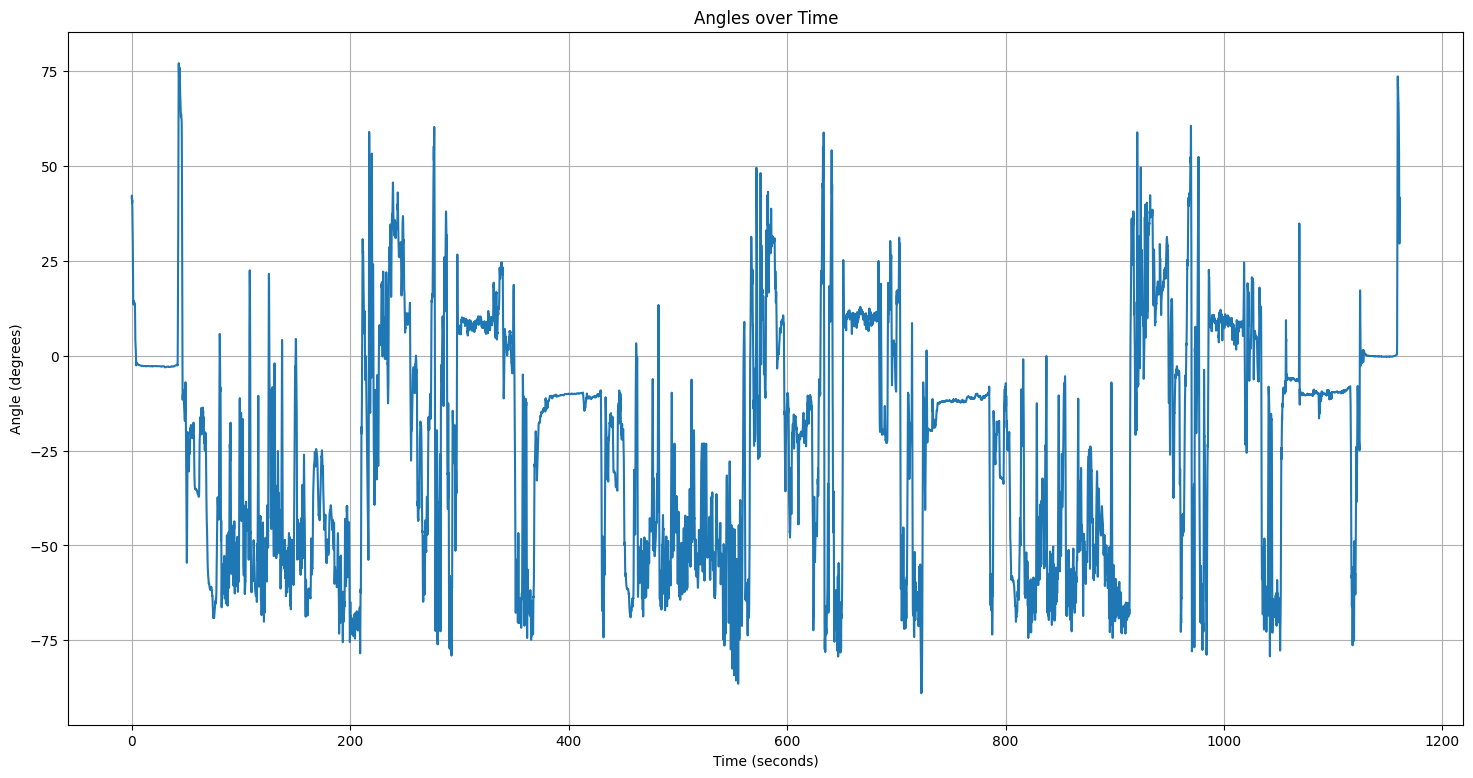

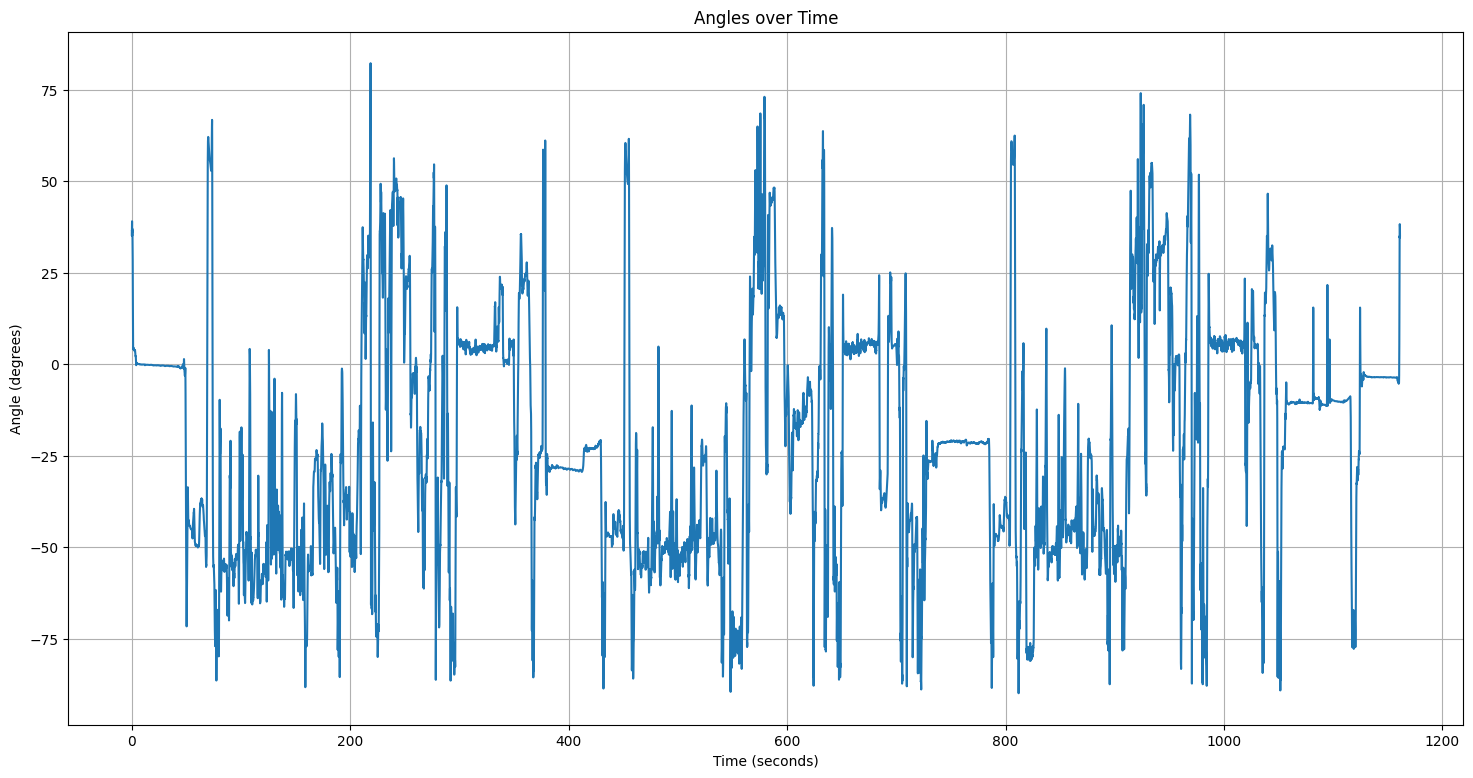

In [111]:
plot_angles_over_time(pitch_dh)
plot_angles_over_time(pitch_ndh)

In [112]:
# Add Euler angles to participant dataset
add_attributes_to_participant(participant_data, pitch_NDH=pitch_ndh, pitch_DH=pitch_dh) #TODO rename to pitch_NDH_50Hz and pitch_DH_50Hz

Resample pitch to 1Hz

In [113]:
df_for_Subash_ndh['pitch'] = pitch_ndh
df_for_Subash_dh['pitch'] = pitch_dh

In [114]:
mean_pitch_NDH = gmac.resample(df_for_Subash_ndh[['pitch']], 50, 1)
mean_pitch_DH = gmac.resample(df_for_Subash_dh[['pitch']], 50, 1)

/Users/linus/Code/imu_processing/src/GMAC.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]
/Users/linus/Code/imu_processing/src/GMAC.py:22: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  dfs = [df.resample(str(round(1 / new_fs, 2)) + 'S', label='right', closed='right').mean() for df in dfs]


### GT MASK Resampling & dropping of excluded frames

In [115]:
# Replace all WBM (whole-body movements) by NF movements inside the GT mask @ 25 Hz 
# Could be changed in the future (e.g. remove all WBM movements)
GT_mask_NDH_25Hz = replace_wbm_with_nf(GT_mask_25Hz_NDH).ravel()
GT_mask_DH_25Hz = replace_wbm_with_nf(GT_mask_25Hz_DH).ravel()

In [116]:
# Downsample GT masks to be used later on for GMAC (1Hz) computation
GT_mask_NDH_1Hz = downsample_mask(GT_mask_NDH_25Hz, FPS_mask, frequency_GMAC)
GT_mask_DH_1Hz = downsample_mask(GT_mask_DH_25Hz, FPS_mask, frequency_GMAC)

In [117]:
# Ensure GT Mask @ 1 hZ have same size as the vector magnitude values 
GT_mask_NDH_1Hz, counts_for_GMAC_ndh = remove_extra_elements(GT_mask_NDH_1Hz, counts_for_GMAC_ndh)
GT_mask_DH_1Hz, counts_for_GMAC_dh = remove_extra_elements(GT_mask_DH_1Hz, counts_for_GMAC_dh)
# Ensure GT Mask @ 1 hZ have same size as the pitch values
GT_mask_NDH_1Hz, mean_pitch_NDH = remove_extra_elements(GT_mask_NDH_1Hz, mean_pitch_NDH)
GT_mask_DH_1Hz, mean_pitch_DH = remove_extra_elements(GT_mask_DH_1Hz, mean_pitch_DH)
GT_mask_NDH_1Hz, counts_for_GMAC_ndh = remove_extra_elements(GT_mask_NDH_1Hz, counts_for_GMAC_ndh)
GT_mask_DH_1Hz, counts_for_GMAC_dh = remove_extra_elements(GT_mask_DH_1Hz, counts_for_GMAC_dh)

Arrays already had same shape.
Arrays already had same shape.
Arrays already had same shape.
Arrays already had same shape.
Arrays already had same shape.
Arrays already had same shape.


remove excluded frames

In [118]:
counts_for_GMAC_ndh, mean_pitch_NDH, GT_mask_NDH_1Hz = remove_excluded_frames(counts_for_GMAC_ndh, mean_pitch_NDH, GT_mask_NDH_1Hz)
counts_for_GMAC_dh, mean_pitch_DH, GT_mask_DH_1Hz = remove_excluded_frames(counts_for_GMAC_dh, mean_pitch_DH, GT_mask_DH_1Hz)

remove nan frames due to filtering in counts

In [119]:
counts_for_GMAC_ndh, mean_pitch_NDH, GT_mask_NDH_1Hz = remove_nan_frames(counts_for_GMAC_ndh, mean_pitch_NDH, GT_mask_NDH_1Hz)
counts_for_GMAC_dh, mean_pitch_DH, GT_mask_DH_1Hz = remove_nan_frames(counts_for_GMAC_dh, mean_pitch_DH, GT_mask_DH_1Hz)

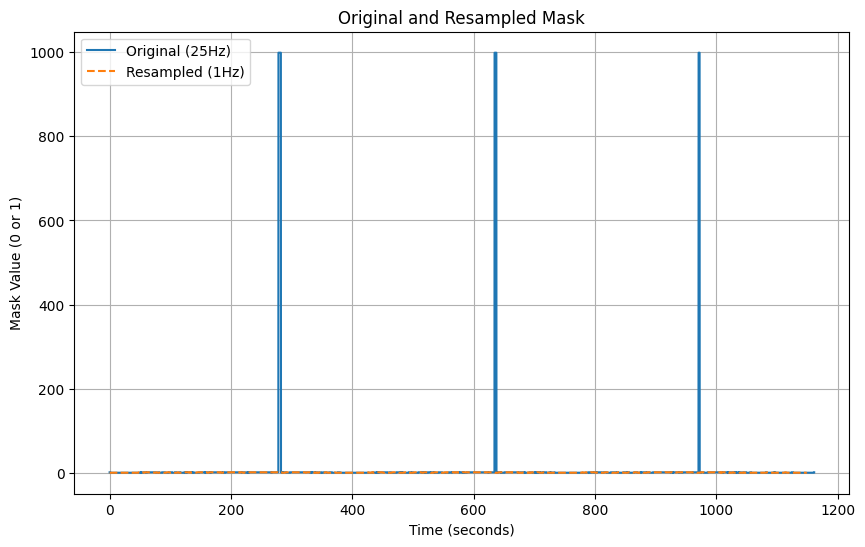

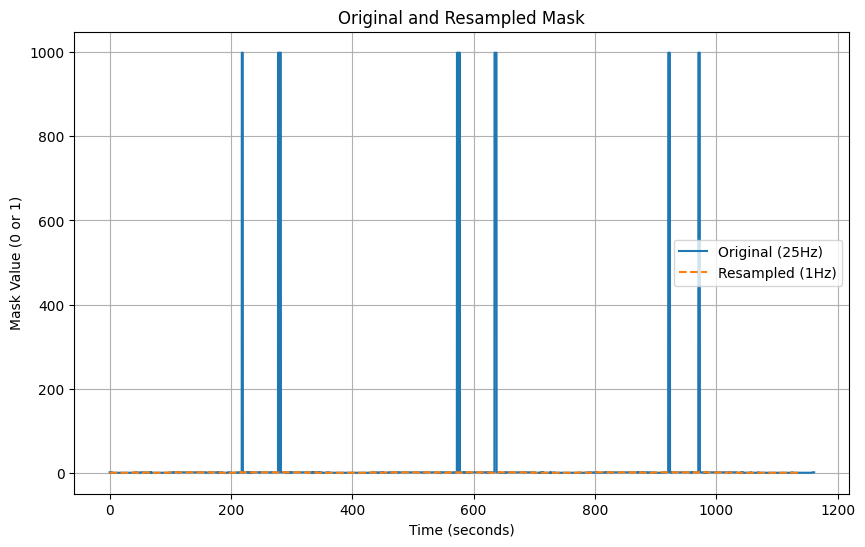

In [120]:
# Plots to ensure the downsampling was correctly done
plot_resampled_arrays(GT_mask_NDH_25Hz, FPS_mask, GT_mask_NDH_1Hz, frequency_GMAC) #TODO plots don't seem correct
plot_resampled_arrays(GT_mask_DH_25Hz, FPS_mask, GT_mask_DH_1Hz, frequency_GMAC)

In [121]:
# Update the participant dataset file with new arrays of usefull data  
# Add vector magnitude
add_attributes_to_participant(participant_data, counts_for_GMAC_ndh=counts_for_GMAC_ndh, counts_for_GMAC_dh=counts_for_GMAC_dh)
# Add mask @ 1 Hz and @ 25 Hz
add_attributes_to_participant(participant_data, GT_mask_NDH_1Hz = GT_mask_NDH_1Hz, GT_mask_DH_1Hz = GT_mask_DH_1Hz, 
                             GT_mask_NDH_25Hz = GT_mask_NDH_25Hz, GT_mask_DH_25Hz = GT_mask_DH_25Hz)

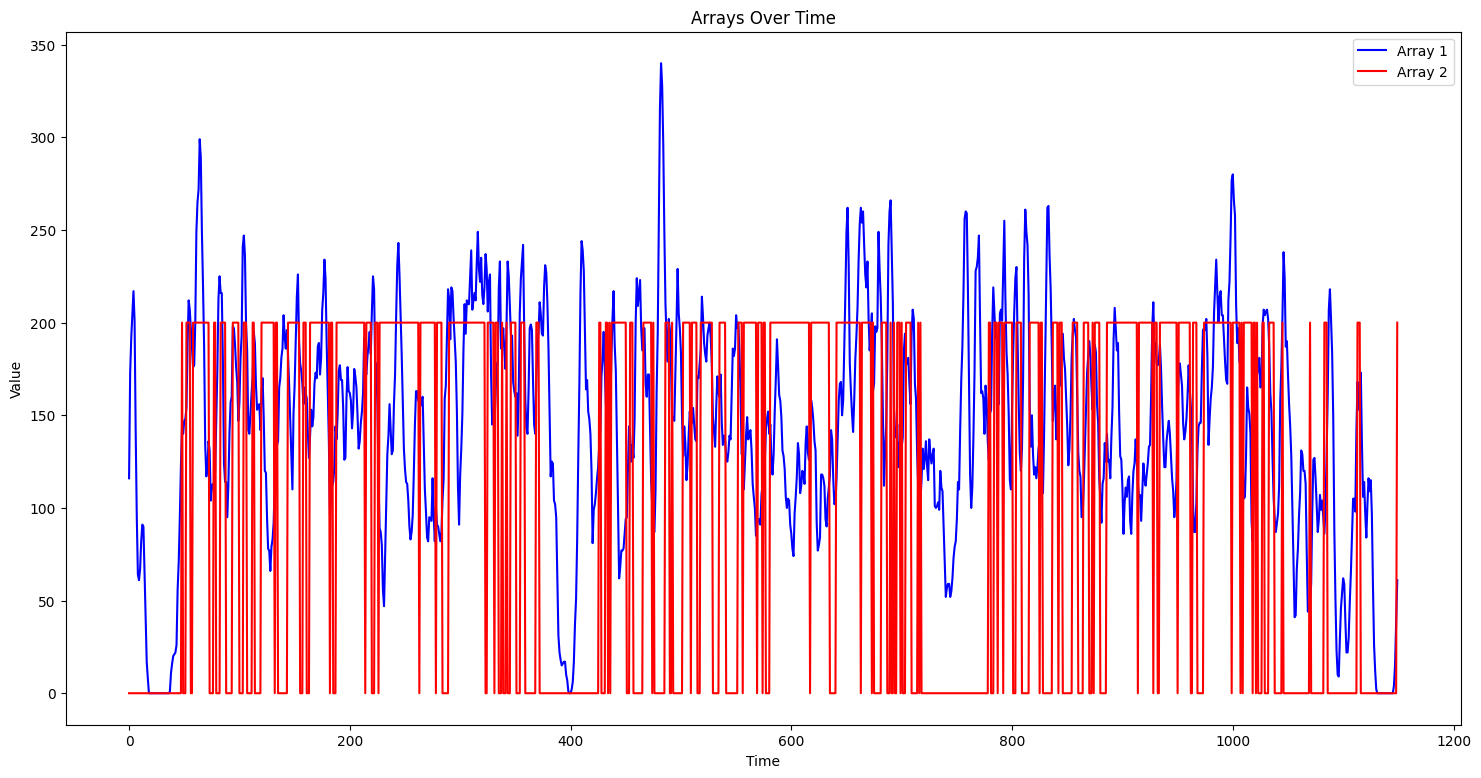

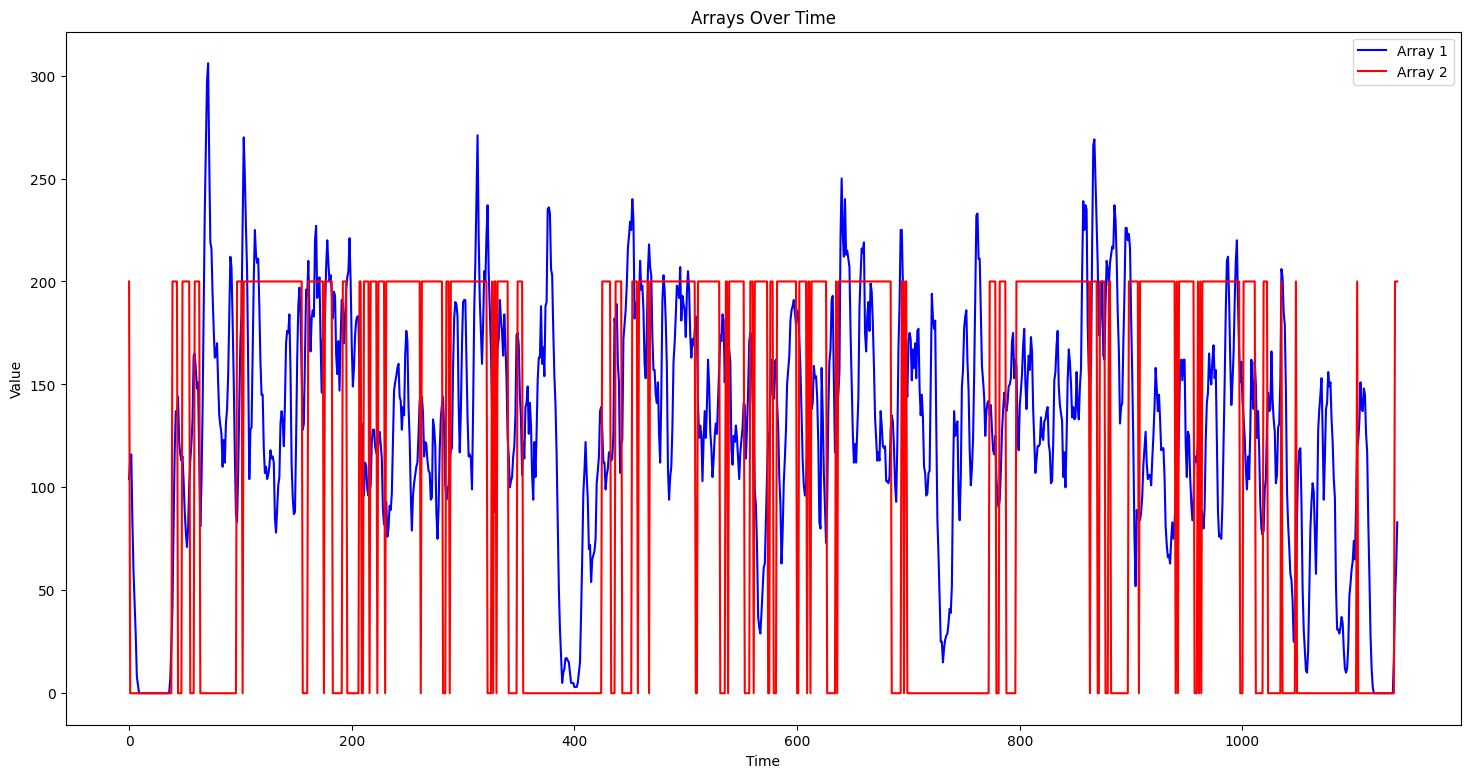

In [122]:
# Plot to visualize counts and GT superposed
plot_superposition(counts_for_GMAC_ndh, 200*GT_mask_NDH_1Hz)
plot_superposition(counts_for_GMAC_dh, 200*GT_mask_DH_1Hz)

## Individual Optimization

In [123]:
from individual_analysis_gmac_function import *

In [124]:
# Perform k-fold cross-validation for the left wrist data
# Return average optimal Count threshold, Pitch threshold and evaluation metrics on this optimal parameter when tested against GT
eval_metrics_opt_ndh, opt_thresholds_ndh, min_max_std_threshold_ndh = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_ndh.ravel(), mean_pitch_NDH['pitch'].values), axis=0).T, y=GT_mask_NDH_1Hz, optimal=True)
# Same but for conventional fixed threshold 
eval_metrics_conv_ndh, conv_thresholds_ndh, _ = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_ndh.ravel(), mean_pitch_NDH['pitch'].values), axis=0).T, y=GT_mask_NDH_1Hz, optimal=False)

Arrays already had same shape.
Iteration 1/5
Optimal Count Threshold: 73.00
Optimal Pitch Threshold: 50.00
Iteration 2/5
Optimal Count Threshold: 73.00
Optimal Pitch Threshold: 51.00
Iteration 3/5
Optimal Count Threshold: 105.00
Optimal Pitch Threshold: 51.00
Iteration 4/5
Optimal Count Threshold: 73.00
Optimal Pitch Threshold: 50.00
Iteration 5/5
Optimal Count Threshold: 76.00
Optimal Pitch Threshold: 50.00
Arrays already had same shape.
Iteration 1/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 2/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 3/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 4/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 5/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00


In [125]:
# Perform k-fold cross-validation for the right wrist data
# Return average optimal Count threshold, Pitch threshold and evaluation metrics on this optimal parameter when tested against GT
eval_metrics_opt_dh, opt_thresholds_dh, min_max_std_threshold_dh = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_dh, mean_pitch_DH['pitch'].values), axis=0).T, y=GT_mask_DH_1Hz, optimal=True)
# Same but for conventional fixed threshold
eval_metrics_conv_dh, conv_thresholds_dh, _ = k_fold_cross_validation_gmac(X=np.stack((counts_for_GMAC_dh, mean_pitch_DH['pitch'].values), axis=0).T, y=GT_mask_DH_1Hz, optimal=False)

Arrays already had same shape.
Iteration 1/5
Optimal Count Threshold: 74.00
Optimal Pitch Threshold: 61.00
Iteration 2/5
Optimal Count Threshold: 74.00
Optimal Pitch Threshold: 58.00
Iteration 3/5
Optimal Count Threshold: 72.00
Optimal Pitch Threshold: 59.00
Iteration 4/5
Optimal Count Threshold: 70.00
Optimal Pitch Threshold: 59.00
Iteration 5/5
Optimal Count Threshold: 74.00
Optimal Pitch Threshold: 59.00
Arrays already had same shape.
Iteration 1/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 2/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 3/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 4/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00
Iteration 5/5
Using conventional threshold
Optimal Count Threshold: 0.00
Optimal Pitch Threshold: 30.00


In [126]:
# Optimal Count and Pitch thresholds for this participant
print("Non Dominant Hand")
print(opt_thresholds_ndh)
print(min_max_std_threshold_ndh) #min, max, std over k-folds
print("Dominant Hand")
print(opt_thresholds_dh)
print(min_max_std_threshold_dh) #min, max, std over k-folds

Non Dominant Hand
(80.0, 50.4)
({'min': 73.0, 'max': 105.0, 'std': 12.553883861180172}, {'min': 50.0, 'max': 51.0, 'std': 0.4898979485566356})
Dominant Hand
(72.8, 59.2)
({'min': 70.0, 'max': 74.0, 'std': 1.5999999999999999}, {'min': 58.0, 'max': 61.0, 'std': 0.9797958971132711})


In [127]:
# Create a structure to save all the evaluation metrics 
metrics_dictionary_GMAC = create_metrics_dictionary(eval_metrics_conv_ndh, eval_metrics_conv_dh, eval_metrics_opt_ndh, eval_metrics_opt_dh)

In [128]:
metrics_dictionary_GMAC

{'OT_ndh_Sensitivity': 80.47961458555798,
 'OT_ndh_Specificity': 47.65200616018389,
 'OT_ndh_Accuracy': 65.47826086956522,
 'OT_ndh_YoudenIndex': 0.28131620745741864,
 'OT_dh_Sensitivity': 88.51259014449819,
 'OT_dh_Specificity': 48.00304623361133,
 'OT_dh_Accuracy': 71.05263157894737,
 'OT_dh_YoudenIndex': 0.3651563637810952,
 'CT_ndh_Sensitivity': 50.13238452866172,
 'CT_ndh_Specificity': 49.84203332495628,
 'CT_ndh_Accuracy': 50.17391304347826,
 'CT_ndh_YoudenIndex': -0.0002558214638199052,
 'CT_dh_Sensitivity': 55.091692550299115,
 'CT_dh_Specificity': 48.03035855368219,
 'CT_dh_Accuracy': 51.92982456140351,
 'CT_dh_YoudenIndex': 0.031220511039813114}

In [129]:
# Add metrics for GMAC threshold evaluation to the JSON file 
add_attributes_to_participant(participant_data, metrics_dictionary_GMAC = metrics_dictionary_GMAC) 
# Add optimal GMAC parameter to the JSON file 
add_attributes_to_participant(participant_data, optimal_GMAC_NDH = opt_thresholds_ndh, optimal_GMAC_DH = opt_thresholds_dh) 
# Add min, max and std of the optimal GMAC parameter to the JSON file
add_attributes_to_participant(participant_data, min_max_std_GMAC_NDH = min_max_std_threshold_ndh, min_max_std_GMAC_DH = min_max_std_threshold_dh)

In [130]:
# Save the JSON file with the new fields 
save_to_json(participant_data, participant_path)

Data saved to: ../data/CreateStudy/S014/S014.json


## Laterality metrics
A Method for Quantifying Upper Limb Performance in Daily Life Using Accelerometers - PMC [Lang et al. 2017] \
_Only based on counts, not on pitch!_

In [131]:
#TODO remove frames in counts if dh or ndh is excluded --> same array length for magnitude calculation

In [132]:
# Bilateral Magnitude 
bilateral_magnitude = compute_bilateral_magnitude(counts_for_GMAC_ndh, counts_for_GMAC_dh)

ValueError: Activity counts arrays must have the same length.

In [ ]:
# Magnitude Ratio
magnitude_ratio = get_magnitude_ratio(counts_for_GMAC_ndh, counts_for_GMAC_dh)

In [ ]:
# Pots to visualize UL usage 
plot_distribution_ratio(magnitude_ratio, non_affected_hand = dominant_hand, saving_path = None)
plot_density(bilateral_magnitude, magnitude_ratio, non_affected_hand = dominant_hand, saving_path = None)